In [1]:
from utils.codification_cnn import ChromosomeCNN, CNNLayer, NNLayer, FitnessCNN
from utils.codifications import Fitness
from GA.geneticAlgorithm import GenerationalGA
from GA.parentSelector.parentSelector import RandomParentSelector, LinealOrder, TournamentSelection
from GA.parentSelector.parentSelector import WheelSelection, LinealOrderII
from utils.datamanager import DataManager

from time import time

Using TensorFlow backend.


In [5]:
import random

class Fitness_str:    
    instances = 0
    
    def __init__(self):
        Fitness_str.instances += 1
    
    def set_params(self, chromosome):
        self.chrom = chromosome
        self.str = chromosome.__repr__()
        self.time = 0
        
    def calc(self, chrom, test=False):
        ti  = time()
        s = chrom.__repr__()
        min_len = min(len(s), len(self.str))
        max_len = max(len(s), len(self.str))
        c = max_len - min_len
        for i in range(min_len):
            c += s[i] != self.str[i]
        self.time += time() - ti
        return c      
    

class Fitness_EvoCNN(FitnessCNN):
    
    def decode(self, chromosome, lr=0.001):

        inp = Input(shape=self.input_shape)
        x = inp
        for i in range(chromosome.n_cnn):
            act = chromosome.cnn_layers[i].activation
            filters = chromosome.cnn_layers[i].filters
            ksize = chromosome.cnn_layers[i].k_size
            if act in ['relu', 'sigmoid', 'tanh', 'elu']:
                x = Conv2D(filters, ksize, activation=act, padding='same')(x)
            elif act == 'prelu':
                x = Conv2D(filters, ksize, padding='same')(x)
                x = PReLU()(x)
            else:
                x = Conv2D(filters, ksize, padding='same')(x)
                x = LeakyReLU()(x)
            #x = BatchNormalization()(x)
            if chromosome.cnn_layers[i].maxpool:
                x = MaxPooling2D()(x)

        x = Flatten()(x)

        for i in range(chromosome.n_nn):
            act = chromosome.nn_layers[i].activation
            if act in ['relu', 'sigmoid', 'tanh', 'elu']:
                x = Dense(chromosome.nn_layers[i].units, activation=act)(x)
            elif act == 'prelu':
                x = Dense(chromosome.nn_layers[i].units)(x)
                x = PReLU()(x)
            else:
                x = Dense(chromosome.nn_layers[i].units)(x)
                x = LeakyReLU()(x)
        x = Dense(self.num_clases, activation='softmax')(x)

        model = Model(inputs=inp, outputs=x)
        if self.verb:
            model.summary()
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr),
                      metrics=['accuracy'])
        return model
    
class CNNLayer_EvoCNN(CNNLayer):
    
    possible_activations = ['relu']
    possible_k = [1, 3, 5, 7]
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.k_size = (self.k_size[0], self.k_size[0])
        self.dropout = 0.
        self.activation = 'relu'
    
    def mutate(self):
        super().mutate()
        self.k_size = (self.k_size[0], self.k_size[0])
        self.dropout = 0.
        self.activation = 'relu'
        
    def cross_kernel(self, other_kernel):
        min_k = min(self.k_size[0], other_kernel[0])
        max_k = max(self.k_size[0], other_kernel[0])
        k = random.choice([k for k in self.possible_k if (k>=min_k and k<=max_k)])
        return k, k
        
class NNLayer_EvoCNN(NNLayer):
    
    possible_activations = ['relu']
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dropout = 0
        self.activation = 'relu'
        
    def mutate(self):
        super().mutate()
        self.dropout = 0
        self.activation = 'relu'
            


In [120]:
ps = {'random':RandomParentSelector(), 'lineal':LinealOrder(), 'wheel':WheelSelection(), 
      'tournament':TournamentSelection(2)}

# EvoCNN Params
ChromosomeCNN.max_layers['CNN'] = 5
ChromosomeCNN.max_layers['NN'] = 5
ChromosomeCNN.layers_types['CNN'] = CNNLayer_EvoCNN
ChromosomeCNN.layers_types['NN'] = NNLayer_EvoCNN
ChromosomeCNN.grow_prob = 1/3.
ChromosomeCNN.decrease_prob = 1/3.

# genetic algorithm params:
parents_selector_key = 'tournament'
num_parents = 0.2
generations = 100
population = 100
train_time = 60
maximize_fit = False
stat_val=False
folder = "../delete"
save_progress = False
p = ps[parents_selector_key]


fitness = Fitness_str()
l = CNNLayer(32, (3,3), 'relu', 0, False)
l2 = CNNLayer(64, (3,3), 'relu', 0.25, True)
l3 = NNLayer(128, 'relu', 0.5)
c = ChromosomeCNN([l, l2], [l3], fitness)

fitness.set_params(c)
'''
# Fitness params
epochs = 10
batch_size = 128
verbose = 0
redu_plat = False
early_stop = False
warm_up_epochs = 0
cosine_decay = False
base_lr = 0.001
smooth = 0

# dataset params:
dataset = 'MRDBI'
data_folder = '../../../../../datasets/MNIST_variations'
classes = []

# Load data
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
data = dm.load_data()
fitness.set_params(data, verbose=verbose, reduce_plateau=redu_plat, epochs=epochs,
                   early_stop=early_stop, warm_epochs=warm_up_epochs, base_lr=base_lr,
                  cosine_decay=cosine_decay)
'''


generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=population, maximize_fitness=maximize_fit, 
                              training_hours=train_time, folder=folder, statistical_validation=stat_val,
                             save_progress=save_progress)

Genetic algorithm params
Number of generations: 100
Population size: 100
num parents: 20
offspring size: 80



Creating Initial population

Start evolution process...

1) best fit: 58.000 in batch time: 0.00 mins
Current winner:
CNN|F:59|K:(7,7)|A:relu|D:0.000|M:1
CNN|F:198|K:(7,7)|A:relu|D:0.000|M:1

11) best fit: 10.000 in batch time: 0.00 mins
Current winner:
CNN|F:90|K:(3,3)|A:relu|D:0.000|M:1
CNN|F:91|K:(3,3)|A:relu|D:0.000|M:1
NN|U:527|A:relu|D:0.000

21) best fit: 8.000 in batch time: 0.00 mins
Current winner:
CNN|F:33|K:(3,3)|A:relu|D:0.000|M:0
CNN|F:95|K:(3,3)|A:relu|D:0.000|M:1
NN|U:508|A:relu|D:0.000

31) best fit: 7.000 in batch time: 0.01 mins
Current winner:
CNN|F:62|K:(3,3)|A:relu|D:0.000|M:0
CNN|F:66|K:(3,3)|A:relu|D:0.000|M:1
NN|U:827|A:relu|D:0.000

41) best fit: 7.000 in batch time: 0.01 mins
Current winner:
CNN|F:62|K:(3,3)|A:relu|D:0.000|M:0
CNN|F:66|K:(3,3)|A:relu|D:0.000|M:1
NN|U:827|A:relu|D:0.000

51) best fit: 7.000 in batch time: 0.01 mins
Current winner:
CNN|F:62|K:(3,3)|A:relu|D:0.000|M:0
CNN|F:66|K:(3,3)|A:relu|D:0.000|M:1
NN|U:827|A:relu|D:0.000

61) best fit: 7.0

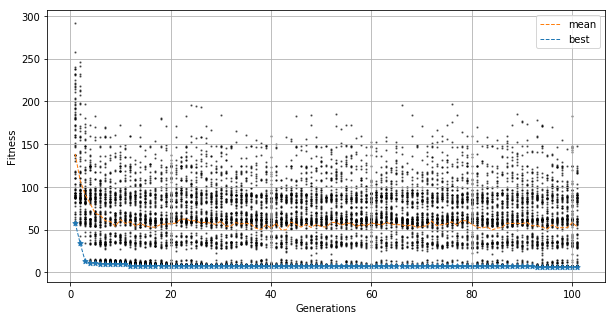

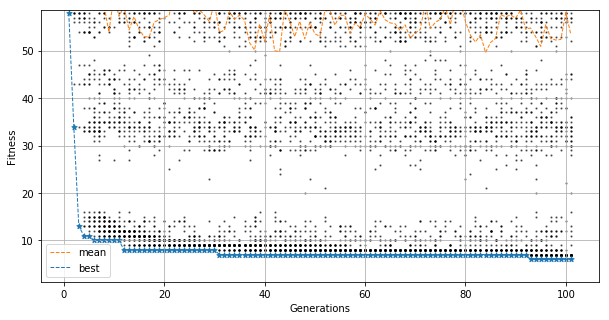

Total elapsed time: 2.515
Total training time: 0.101


In [121]:
ti_all = time()
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))
print("Total training time: %0.3f" % fitness.time)

In [ ]:
class A(object):
    name = 'A'
    
    def get_A(self):
        return self.get()
    
    @classmethod
    def get(cls, **kwargs):
        return cls(**kwargs)
    
class B(A):
    name = 'B'
    
    def get_B(self):
        return self.get(n=10)
    
    def __init__(self, n, **kwargs):
        super().__init__(**kwargs)
        self.n = n
    
a = A()
print(a.name)

In [ ]:
b = B(1)
print(b.name, b.n)

In [ ]:
a2 = a.get()
print(a2.name)

In [ ]:
b2 = b.get(n=2)
print(b2.name)

In [ ]:
a3 = a.get_A()
print(a3.name)

In [ ]:
class A(object):
    
    def __init__(self, n=0, **kwargs):
        self.n = n
        
    def __repr__(self):
        return "%d" % self.n
    
    def create(self, **kwargs):
        return self.__class__(**kwargs)
    
    @classmethod
    def create_class(cls, **kwargs):
        return cls(**kwargs)
    
class B(A):
    
    def __init__(self, m=1, **kwargs):
        super().__init__(**kwargs)
        self.m = m
        
    def __repr__(self):
        return "%d, %d" % (self.n, self.m)
        
a = A(1, fake=3)
print(a)

b = B(m=3, n=4)
print(b)

In [ ]:
a2 = a.create(n=10, fake=8)
print(a2)

In [ ]:
b2 = b.create(n=20, m=30, fake=40)
print(b2)

In [ ]:
a3 = A.create_class(n=10, m=20, fake=40)
print(a3)

In [ ]:
b3 = B.create_class()
print(b3)

In [ ]:
a = [1,3,5,7]
import random


def cross_kernel(self, other_kernel):
    min_k = min(self, other_kernel)
    max_k = max(self, other_kernel)
    k = random.choice([k for k in a if (k>=min_k and k<=max_k)])
    return k

In [ ]:
a1 = 1
b = 7
for _ in range(100):
    assert cross_kernel(a1,b) in [1,3,5,7]

In [11]:
import tensorflow as tf
import numpy as np
from random import randint, seed

n_train_samples = 50000 # number of train samples
n_test_samples = 10000 # number of test samples

groups = np.append(np.zeros(8),np.ones(8)) # 16 groups
np.random.seed(1234)
np.random.shuffle(groups)

# generate samples
seed(1234)
def generate_samples(n_samples):
    x_data = np.zeros((n_samples, 10)) # inputs
    x_int = np.zeros(n_samples) # integers representing the inputs
    y_data = np.zeros((n_samples, 2)) # outputs
    
    for i in range(n_samples):
        random_int = randint(0, 1023)
        x_data[i,:] = [int(b) for b in list("{0:b}".format(random_int).zfill(10))]
        x_int[i] = random_int
        y_data[i,0] = groups[random_int % 16]
        y_data[i,1] = 1 - y_data[i,0]
        
    return x_data, y_data, x_int

x_train, y_train, x_train_int = generate_samples(n_train_samples) # training dataset
x_test, y_test, _ = generate_samples(n_test_samples) # testing dataset

print(x_train[0])
print(x_train.shape)

[1. 1. 1. 0. 0. 0. 0. 1. 1. 0.]
(50000, 10)


In [87]:
import tensorflow as tf

def fully_conn(tensor, n_outputs, name):
    tf.set_random_seed(time())
    size = tensor.get_shape().as_list()[1]
    
    # weight and bias tensor
    weight = tf.Variable(tf.truncated_normal([size, n_outputs]))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # fully-connected layer
    tensor = tf.matmul(tensor, weight)
    tensor = tf.nn.bias_add(tensor, bias)
    
    # hyperbolic tangent activation
    tensor = tf.tanh(tensor, name=name)
    
    return tensor

def output(tensor, n_outputs):
    size = tensor.get_shape().as_list()[1]
    
    # weight and bias tensor
    weight = tf.Variable(tf.truncated_normal([size, n_outputs]))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # fully-connected layer
    tensor = tf.matmul(tensor, weight)
    tensor = tf.nn.bias_add(tensor, bias)
    
    return tensor

In [88]:
def mlp(x, n_neurons, id_): # x is the input layer    
    # hidden layers
    hidden = x
    for n in range(len(n_neurons)):
        hidden = fully_conn(hidden, n_neurons[n], 'hidden%s_%d'% (n+1, id_))
    
    # output layer
    y = output(hidden, 2)
    
    return y

In [89]:
def build_network(hidden_layer_neurons, id_=0):
    global x, y, logits, cost, optimizer, accuracy
    
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, (None, 10), name='x')
    y = tf.placeholder(tf.float32, (None, 2), name='y')

    tf.set_random_seed(123456)
    logits = mlp(x, hidden_layer_neurons, id_)
    logits = tf.identity(logits, name='logits_'+str(id_))

    # cross-entropy coss function
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y), name='cost_'+str(id_))
    
    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
    
    # accuracy
    correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy_'+str(id_))
    
def print_out_summary(sess, epoch):
    acc, loss = sess.run([accuracy, cost], feed_dict={x: x_test, y: y_test})
    print('Epoch {:>4}:  Testing accuracy {:>.4f} - Testing loss {:>.4f}'.format(epoch, acc, loss))
    
def build_ensamble(hidden_layer_neurons, ids_=[]):
    global x, y, logits, cost, optimizer, accuracy
    
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, (None, 10), name='x')
    y = tf.placeholder(tf.float32, (None, 2), name='y')

    tf.set_random_seed(123456)
    logits_ensamble = []
    for id_ in ids_:
        logits = mlp(x, hidden_layer_neurons, id_)
        logits = tf.identity(logits, name='logits_'+str(id_))
        logits_ensamble.append(logits)
    final_logits = tf.stack(logits_ensamble, axis=0)
    final_logits = tf.reduce_mean(final_logits, axis=0)
    # cross-entropy coss function
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=final_logits, labels=y), name='cost_'+str(id_))
    
    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
    
    # accuracy
    correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy_'+str(id_))

In [116]:
n_epochs = 300
for i in range(3):
    build_network([12,10,7,5,4,3], i) # 3 hidden layers with 8, 6 and 4 neurons respectively

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    with tf.name_scope("my_scope"):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer()) # initialization

            for epoch in range(n_epochs):
                sess.run(optimizer, feed_dict={x: x_train, y: y_train})
                if epoch % 100 == 0: print_out_summary(sess, epoch)

            acc = sess.run(accuracy, feed_dict={x: x_test, y: y_test})
            print("Test acc: %0.4f" % acc)
            # Save the variables to disk.
            save_path = saver.save(sess, "./tmp_%d/model.ckpt" %i)
            print("Model saved in path: %s" % save_path)

Epoch    0:  Testing accuracy 0.5381 - Testing loss 0.7088
Epoch  100:  Testing accuracy 0.5797 - Testing loss 0.6781
Epoch  200:  Testing accuracy 0.6056 - Testing loss 0.6652
Test acc: 0.6458
Model saved in path: ./tmp_0/model.ckpt
Epoch    0:  Testing accuracy 0.4877 - Testing loss 0.7665
Epoch  100:  Testing accuracy 0.5544 - Testing loss 0.6845
Epoch  200:  Testing accuracy 0.6173 - Testing loss 0.6669
Test acc: 0.6820
Model saved in path: ./tmp_1/model.ckpt
Epoch    0:  Testing accuracy 0.5133 - Testing loss 0.9135
Epoch  100:  Testing accuracy 0.5625 - Testing loss 0.6944
Epoch  200:  Testing accuracy 0.5757 - Testing loss 0.6837
Test acc: 0.5968
Model saved in path: ./tmp_2/model.ckpt


In [115]:
tf.reset_default_graph()

build_network([12,10,7,5,4,3], i) # 3 hidden layers with 8, 6 and 4 neurons respectively



# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    logits_ensamble = []
    for i in range(3):
        saver.restore(sess, "./tmp_%d/model.ckpt" % i)
        print("Model restored.")
        # Check the values of the variables
        logits_, acc = sess.run([logits, accuracy], feed_dict={x: x_test, y: y_test})
        logits_ensamble.append(logits_)
        print("Test acc %d: %0.4f" % (i, acc))
            
    logits_ensamble = np.stack(logits_ensamble, axis=0)
    logits_ensamble = np.mean(logits_ensamble, axis=0)

    correct_predictions = np.argmax(logits_ensamble, 1) == np.argmax(y_test, 1)
    accuracy =np.mean(correct_predictions.astype(np.float32))
    print(accuracy)

INFO:tensorflow:Restoring parameters from ./tmp_0/model.ckpt
Model restored.
Test acc 0: 0.6633
INFO:tensorflow:Restoring parameters from ./tmp_1/model.ckpt
Model restored.
Test acc 1: 0.6010
INFO:tensorflow:Restoring parameters from ./tmp_2/model.ckpt
Model restored.
Test acc 2: 0.6745
0.693


In [101]:
logits_ensamble.shape


(50000, 2)

In [69]:
tf.reset_default_graph()

n_epochs = 300
build_ensamble([12,10,7,5,4,3], [0,1,2]) # 3 hidden layers with 8, 6 and 4 neurons respectively

# Add ops to save and restore all the variables.
saver = tf.train.Saver()


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # initialization

    for epoch in range(n_epochs):
        sess.run(optimizer, feed_dict={x: x_train, y: y_train})
        if epoch % 100 == 0: print_out_summary(sess, epoch)

    # Save the variables to disk.
    save_path = saver.save(sess, "./tmp_%d/model.ckpt" %i)
    print("Model saved in path: %s" % save_path)

Epoch    0:  Testing accuracy 0.4774 - Testing loss 0.7361
Epoch  100:  Testing accuracy 0.5638 - Testing loss 0.6604
Epoch  200:  Testing accuracy 0.6138 - Testing loss 0.6220
Model saved in path: ./tmp_0/model.ckpt


In [65]:
tf.stack?